In [13]:
from GNN import simpleGNN
from Graphs.SMILEStoGraph import SMILEStoGraph
import pandas as pd
import torch

torch.set_default_dtype(torch.float64)

solvents = pd.read_csv("/home/stefan/GIT_Repositories/GraphNeuralNetworks/Solvents.txt")
solvents = solvents.dropna(subset=["BP"])
solvents = solvents["SMILES"].tolist()
solvents = [SMILEStoGraph(smile) for smile in solvents]


In [14]:
train_V = []
train_E = []
train_A = []
train_G = []

for solvent in solvents:
    train_V.append(torch.tensor(solvent.vert_vals, dtype=torch.float64))
    train_E.append(torch.tensor(solvent.edge_matrix, dtype=torch.float64))
    train_A.append(torch.tensor(solvent.adj_matrix, dtype=torch.float64))
    train_G.append(torch.tensor(solvent.global_vals["BP"], dtype=torch.float64))
    # solvent.adj_matrix
    # solvent.edge_matrix
    # solvent.vert_vals


In [16]:
import torch.optim as optim


# Define the model
model = simpleGNN(
    node_in=1,
    edge_in=1,
    hidden_dim=25,
    node_out=5,
    edge_out=5,
    global_out=1,
    num_gcn_layers=2
    )

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function (e.g., MSE for regression)
loss_fn = torch.nn.MSELoss()

# Number of epochs
num_epochs = 10000

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Iterate through the training data
    total_loss = 0
    for X, E, A, target in zip(train_V, train_E, train_A, train_G):
        # Forward pass
        output = model(X, E, A)  # X: [N, node_feat], E: [N, N, edge_feat], A: [N, N]
        
        # Compute loss
        loss = loss_fn(output, target.unsqueeze(0))  # target: scalar, unsqueeze to match dimensions
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()

    # Print epoch loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_G):.4f}")

# for solvent in solvents:
#     print(solvent.COSMO_name)
#     print(solvent.global_vals)
#     print(solvent.global_vals["BP"])
    

Epoch 1/10000, Loss: 31592.2018
Epoch 2/10000, Loss: 30687.6976
Epoch 3/10000, Loss: 28133.9760
Epoch 4/10000, Loss: 20362.3154
Epoch 5/10000, Loss: 4847.8538
Epoch 6/10000, Loss: 2474.2591
Epoch 7/10000, Loss: 4707.1768
Epoch 8/10000, Loss: 531.3670
Epoch 9/10000, Loss: 480.2136
Epoch 10/10000, Loss: 587.5230
Epoch 11/10000, Loss: 351.8376
Epoch 12/10000, Loss: 362.9463
Epoch 13/10000, Loss: 296.2161
Epoch 14/10000, Loss: 322.7679
Epoch 15/10000, Loss: 288.7251
Epoch 16/10000, Loss: 324.5303
Epoch 17/10000, Loss: 289.8453
Epoch 18/10000, Loss: 353.4515
Epoch 19/10000, Loss: 308.1772
Epoch 20/10000, Loss: 465.2813
Epoch 21/10000, Loss: 432.8281
Epoch 22/10000, Loss: 941.9076
Epoch 23/10000, Loss: 996.1663
Epoch 24/10000, Loss: 2611.5428
Epoch 25/10000, Loss: 1152.5215
Epoch 26/10000, Loss: 2386.2259
Epoch 27/10000, Loss: 727.7173
Epoch 28/10000, Loss: 973.1688
Epoch 29/10000, Loss: 499.3665
Epoch 30/10000, Loss: 694.6544
Epoch 31/10000, Loss: 445.9063
Epoch 32/10000, Loss: 658.0321
Epo

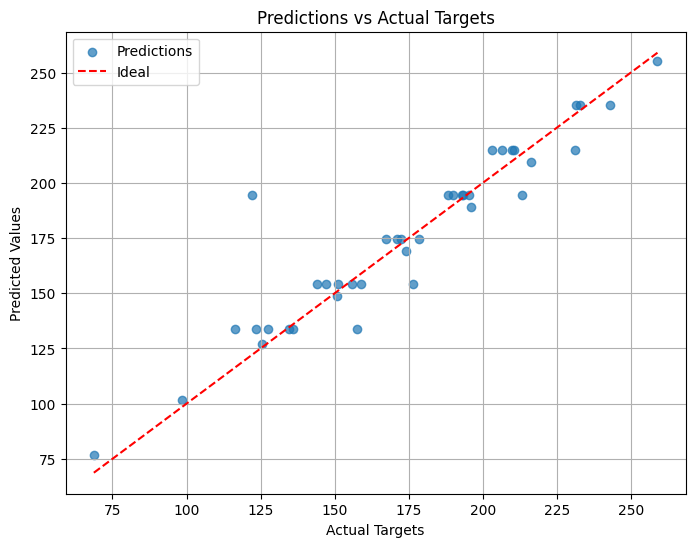

In [17]:
import matplotlib.pyplot as plt

# Collect predictions and targets
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for X, E, A, target in zip(train_V, train_E, train_A, train_G):
        output = model(X, E, A)
        predictions.append(output.item())
        targets.append(target.item())

# Plot predictions vs targets
plt.figure(figsize=(8, 6))
plt.scatter(targets, predictions, alpha=0.7, label="Predictions")
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--', label="Ideal")
plt.xlabel("Actual Targets")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual Targets")
plt.legend()
plt.grid()
plt.show()

In [21]:
solvents_woBP = pd.read_csv("/home/stefan/GIT_Repositories/GraphNeuralNetworks/Solvents.txt")
solvents_woBP = solvents_woBP[solvents_woBP["BP"].isna()]
solvents_woBP = solvents_woBP["SMILES"].tolist()
solvents_woBP = [SMILEStoGraph(smile) for smile in solvents_woBP]

In [39]:
Atom = 3
print(solvents_woBP[Atom].COSMO_name)
eval_E = torch.tensor(solvents_woBP[Atom].edge_matrix, dtype=torch.float64)
eval_V = torch.tensor(solvents_woBP[Atom].vert_vals, dtype=torch.float64)
eval_A = torch.tensor(solvents_woBP[Atom].adj_matrix, dtype=torch.float64)

octanol_BP_pred = model(eval_V, eval_E, eval_A)
print(f"Predicted BP for {solvents_woBP[Atom].COSMO_name}: ", octanol_BP_pred.item())

4-octanone
Predicted BP for 4-octanone:  174.4574908412347


In [ ]:
target_dict = {
    "3-heptanol" : 156,
    "1-octanol" : 195,
    "3-decanol" : 213, # 
    "4-octanol" : 175, # in the literature 174-176
}

In [41]:
solvents[0].COSMO_name
solvents[0].plot()